# Numerical model of a mediated Glucose Oxidase electrode 

Here we will solve the material balance for an electrode comprising the enzyme glucose oxidase co-immobilized in a hydrogel with the redox polymer mediator poly{N-vinylimidazole [Os(bipyridine)<sub>2</sub>Cl]<sup>+/2+</sup>}. The governing equations and boundary conditions are adapted from <a href="http://dx.doi.org/10.1016/0022-0728(95)04236-7">Bartlett and Pratt, 1995</a>:

$$ -\frac{dN_M}{dx}= D_M\frac{d^2M}{dx^2}=\frac{\nu_M k_M k_{cat} E M S}{k_M M (K_S+S) + k_{cat}S} $$    
$$ -\frac{dN_S}{dx}= D_S\frac{d^2S}{dx^2}=\frac{\nu_S k_M k_{cat} E M S}{k_M M (K_S+S) + k_{cat}S} $$    

at x=0: $V=U+\frac{nF}{RT}log\frac{M}{M_{tot}-M}$, $\frac{dS}{dx}=0$

at x=L: $\frac{dM}{dx}=0$, $S=S_0$

<span style="color:green">Please send comments or suggestions to scb at msu dot edu.</span>

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import scikits.bvp1lg as bvp
from scipy.interpolate import interp1d

### Parameters

Parameters are taken from Ref. 1 and 2 and are typical of that system.

In [7]:
DM = 2.18e-9       # Mediator diffusivity,cm^s2/s
DS = 7e-6          # Substrate (glucose) diffusivity, cm^2/s [Calvo 2006]
ET   = 17.96e-6    # Total enzyme concentration, mol/cm^3 
ST   = 50e-6       # Bulk substrate concentration, mol/cm^3
Mtot   = 659.7e-6  # Total mediator concentration, mol/cm^3
kcat = 17.3        # Enzyme Turnover, s^-1
kM   = 212e3       # second order rate constant for mediator, cm^3/mol/s            
KS   = 12.3e-6     # Michaelis constant for substrate, mol/cm^3
vm = 1.            # Stoichiometric coeff. of mediator
vs = 0.5           # Stoichiometric coeff. of substrate
U = 0.43           # Mediator redox potential, V re:SHE
V  = 0.6           # Electrode potential, V re:SHE
n  = 1.            # Electron transfer coefficient 
R  = 8.314         # Gas constant, J/mol/K
F  = 96485.4       # Faraday's constant, C/mol
T  = 313           # Temperature, K
L  = 1e-4          # Hydrogel film thickness, cm
p     = 1.         # Substrate hydrogel-solution partition coefficient

### Nondimensionalization

We nondimensionalize the system according to the scheme of <a href="http://dx.doi.org/10.1016/0022-0728(95)04236-7">Bartlett and Pratt, 1995</a>:

In [8]:
kappa=L*sqrt(vm*kM*ET/DM)
eta=(vm*DS*kM*KS)/(vs*DM*kcat)
gamma=(kM*Mtot*KS)/(kcat*ST)
mu=(ST/KS)

eps = (n * F * (V-U))/(R*T)    # From the Nernst equation
ae = 1/(1+exp(-eps))            # Dimensionless potential boundary condition at the electrode surface from the Nernst eqn

### Numerical Solution

We will solve this problem numerically using the python package [bvp_solver](https://pypi.python.org/pypi/scikits.bvp_solver)

In [9]:
degrees = [1, 1, 1, 1] 

def deq(x,z):  # z=[m(x) vm(x) s(x) vs(x)];

    m, vm, s, vs = z

    Ra= kappa**2*m*s/(gamma*m*(1+mu*s)+s) 
    dvmdx= Ra
    dmdx= vm
    
    dvsdx= gamma/eta*Ra
    dsdx= vs
    
    dzdx= array([dmdx,dvmdx,dsdx,dvsdx]); return dzdx

In [10]:
boundary_points = [0, 0, 1, 1]

def bc(z):
 
    a, va, s, vs = z
       
    res=   array([  a[0] - 1/(1+exp(-eps)),      # Nernst BC on a at electrode-film interface
                   vs[1],                      # Zero flux BC on s at electrode-film interface
                   va[2],                        # Zero flux BC on a at film-solution interface
                    s[3] - 1 ] )                # Concentration BC on s at film-solution interface
 
    return res

In [11]:
def guess(x):
    v = ones_like(x)
    dv= zeros_like(x)
    u= array([v, dv, v, dv])
    du = array([dv, dv, dv, dv])
    return u, du

In [14]:
tol = [1e-6, 0, 1e-6, 0]

solution = bvp.colnew.solve(
    boundary_points, degrees, deq, bc,
    tolerances=tol,
    vectorized=True, maximum_mesh_size=300, initial_guess=guess)

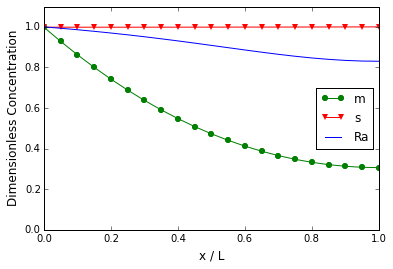

In [18]:
x=solution.mesh
y=solution(x)
m=y[:,0]
s=y[:,2]

Ra= kappa**2*m*s/(gamma*m*(1+mu*s)+s)
Ra=Ra/amax(Ra)

plot(x,m,'-og')
plot(x,s,'-vr')
plot(x,Ra,'b')
legend(['m','s','Ra'],loc='center right')
xlabel('x / L')
ylabel('Dimensionless Concentration')
ylim((0,1.1))

show()

We can see that, for this case, the substrate concentration (s) is uniform, and there is only mass transfer limitations for the mediator (m). The reaction rate, Ra, varies nonlinearly with mediator concentration.

## Polarization Curve

The above numerical treatment can be enclosed in a function to calculate a polarization curve

In [108]:
def polcurve(V,ST,L):
    
    kappa=L*sqrt(vm*kM*ET/DM)
    eta=(vm*DS*kM*KS)/(vs*DM*kcat)
    gamma=(kM*Mtot*KS)/(kcat*ST)
    mu=(ST/KS)

    eps = (n * F * (V-U))/(R*T)    # From the Nernst equation
    ae = 1/(1+exp(-eps))            # Dimensionless potential boundary condition at the electrode surface from the Nernst eqn


    def deq(x,z):  # z=[a(x) va(x) s(x) vs(x)];

        a, va, s, vs = z

        Ra= kappa**2*a*s/(gamma*a*(1+mu*s)+s) * (a >= 0) * (s >= 0)
        dvadx= Ra
        dadx= va

        dvsdx= gamma/eta*Ra
        dsdx= vs

        dzdx= array([dadx,dvadx,dsdx,dvsdx]); return dzdx


    def bc(z0,z1):

        a0, va0, s0, vs0 = z0
        a1, va1, s1, vs1 = z1

        res= ( array([  a0 - 1/(1+exp(-eps)),      # Nernst BC on a at electrode-film interface
                       vs0 ]),                      # Zero flux BC on s at electrode-film interface

               array([ va1,                        # Zero flux BC on a at film-solution interface
                        s1 - 1 ] ) )               # Concentration BC on s at film-solution interface

        return res

    problem = scikits.bvp_solver.ProblemDefinition(num_ODE = 4,
                                          num_parameters = 0,
                                          num_left_boundary_conditions = 2,
                                          boundary_points = (0, 1),
                                          function = deq,
                                          boundary_conditions = bc)
    
    xinit=hstack((0,logspace(-3,0,121)))
    
    solution = scikits.bvp_solver.solve(problem,
                            solution_guess = (1,0,1,0),
                            #initial_mesh = xinit,
                            max_subintervals = 10000,
                            trace=0 )

    x = linspace(0,1)
    y=solution(x)
    icd=-n*F/vm*DM*Mtot/L*y[1,0]
    
    return icd

We now can calculate polarization curves for three different film thicknesses (L):

In [109]:
V=linspace(0,1,80)

pv=vectorize(polcurve)
icdp5=pv(V,ST,0.5e-4)
icd1=pv(V,ST,1e-4)
icd2=pv(V,ST,2e-4)

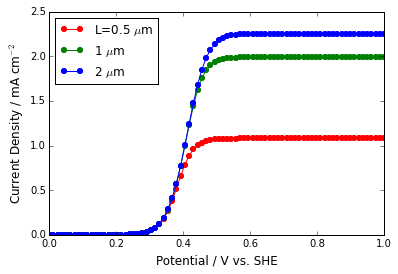

In [111]:
fp5, = plot(V, icdp5*1000,'-or' )
f1,  = plot(V, icd1 *1000,'-og' )
f2,  = plot(V, icd2 *1000,'-ob' )
xlabel('Potential / V vs. SHE')
ylabel('Current Density / mA cm$^{-2}$')
legend([fp5, f1, f2],['L=0.5 $\mu$m','1 $\mu$m','2 $\mu$m'],loc=2)
show()

We see that the plateau current approximately doubles from L=0.5 to 1 $\mu$m, but increases only a small amount at L=2 $\mu$m, due to mediator mass transport limitations that lead to reduced utilization. 

## Porous electrode model

### New parameters:

In [13]:
Lp= 100e-4   # cm, electrode thickness
a= 0.16e4    # cm^-1, carbon surface area per unit volume
eps=0.7      # porosity

DSe= DS*eps**1.5;    # Effective diffusivity of substrate due to porosity, eps (Bruggeman relation)

In [14]:
def porous(V,S0,L):
    
    # Effective thickness of hydrogel film due to roughness a*Lp, 
    # with loading, L, corresponding to the film thickness described previously.

    tp= 2*L/(a*Lp) 
    
    # We first create a lookup table, Rp(Sv) for local glucose consumption rate 
    # as a function of glucose concentration at this potential
    
    Sv=ST*logspace(-6,2,81)
    jS=pv(V,Sv,tp) * a * vs / n / F
    Rp= interp1d(Sv,jS)
    
    def deq(y,u):  # u=[s(y) vs(y)];

        S, vS = u

        dvSdy= Rp(S)/DSe
        dSdy= vS

        dudy= array([dSdy, dvSdy]); return dudy
    
    def bc(uL,uR):

        SL, vSL = uL
        SR, vSR = uR


        res= ( array([ vSL ]), array([ SR - S0 ] ) )               # Concentration BC on s at film-solution interface

        return res


    problem = scikits.bvp_solver.ProblemDefinition(num_ODE = 2,
                                          num_parameters = 0,
                                          num_left_boundary_conditions = 1,
                                          boundary_points = (0, Lp),
                                          function = deq,
                                          boundary_conditions = bc)
    
    solution = scikits.bvp_solver.solve(problem,
                            solution_guess = (S0,0), 
                            tolerance = 1.0e-3,
                            trace=1 )

    x = linspace(0,Lp)
    y=solution(x)
    icd=+n*F/vs*DSe*y[1,-1]
    
    return icd


We again calculate polarization curves for three different film thicknesses, L, now using the porous model.

In [18]:
porv=vectorize(porous)
icpp5=porv(V,ST,0.5e-4)
icp1= porv(V,ST,1e-4)
icp2= porv(V,ST,2e-4)

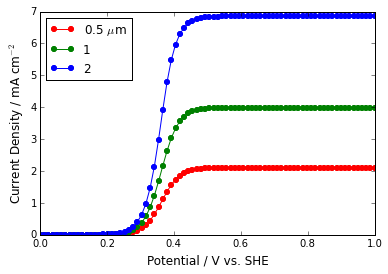

In [21]:
fp5, = plot(V, icpp5*1000,'-or' )
f1,  = plot(V, icp1 *1000,'-og' )
f2,  = plot(V, icp2 *1000,'-ob' )
xlabel('Potential / V vs. SHE')
ylabel('Current Density / mA cm$^{-2}$')
legend([fp5, f1, f2],['0.5 $\mu$m','1','2'],loc=2)
show()

In the case of the porous electrode, the plateau current nearly doubles for eaching doubling of the loading. The reason why the plateau does not reach 8 mA cm<sup>-2</sup> for L=2 $\mu$m is that substrate transport becomes rate limiting. 

## Cell Polarization

For cell polarization, we define a cathode and calculate its polarization curve.  We then match current densities and calculate overall cell polarization. With this approach, we neglect transport limitations external to the electrodes.

In [27]:
def catcurve(V,ST,L):
    
    kcat=100
    n=4
    vm=4
    vs=1
    U = 0.8
    
    kappa=L*sqrt(vm*kM*ET/DM)
    eta=(vm*DS*kM*KS)/(vs*DM*kcat)
    gamma=(kM*Mtot*KS)/(kcat*ST)
    mu=(ST/KS)

    eps = -(n * F * (V-U))/(R*T)    # From the Nernst equation
    ae = 1/(1+exp(-eps))            # Dimensionless potential boundary condition at the electrode surface from the Nernst eqn


    def deq(x,z):  # z=[a(x) va(x) s(x) vs(x)];

        a, va, s, vs = z

        Ra= kappa**2*a*s/(gamma*a*(1+mu*s)+s) * (a >= 0) * (s >= 0)
        dvadx= Ra
        dadx= va

        dvsdx= gamma/eta*Ra
        dsdx= vs

        dzdx= array([dadx,dvadx,dsdx,dvsdx]); return dzdx


    def bc(z0,z1):

        a0, va0, s0, vs0 = z0
        a1, va1, s1, vs1 = z1

        res= ( array([  a0 - 1/(1+exp(-eps)),      # Nernst BC on a at electrode-film interface
                       vs0 ]),                      # Zero flux BC on s at electrode-film interface

               array([ va1,                        # Zero flux BC on a at film-solution interface
                        s1 - 1 ] ) )               # Concentration BC on s at film-solution interface

        return res

    problem = scikits.bvp_solver.ProblemDefinition(num_ODE = 4,
                                          num_parameters = 0,
                                          num_left_boundary_conditions = 2,
                                          boundary_points = (0, 1),
                                          function = deq,
                                          boundary_conditions = bc)
    
    solution = scikits.bvp_solver.solve(problem,
                            solution_guess = (1,0,1,0), trace=1 )

    x = linspace(0,1)
    y=solution(x)
    icd=-n*F/vm*DM*Mtot/L*y[1,0]
    
    return icd

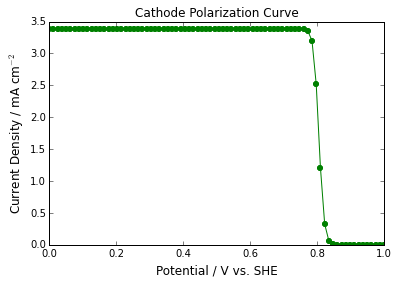

In [37]:
STc=1e-6
cv=vectorize(catcurve)
icd_cat=cv(V,STc,L)
plot(V,icd_cat*1000,'-og')
xlabel('Potential / V vs. SHE')
ylabel('Current Density / mA cm$^{-2}$')
title('Cathode Polarization Curve')
show()

Interpolate the anode and polarization curves in terms of current density

In [38]:
pv_i=interp1d(icd1,V)
cv_i= interp1d(icd_cat,V)

Define a range of current densities up to the smallest maximum current density of either the anode or cathode. 

In [50]:
imax= amin(amax(array([icd1,icd_cat]),axis=1))
icell=imax*logspace(-3,0,121)

Calculate a Cell potential by taking the difference in cathode and anode potentials over this current density range.

In [51]:
V_cell=cv_i(icell)-pv_i(icell)

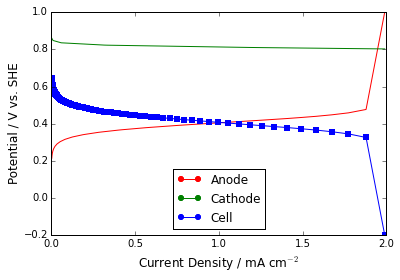

In [62]:
fa,    =plot(icell*1000, pv_i(icell),'-')
fc,    =plot(icell*1000, cv_i(icell),'-')
fcell, =plot(icell*1000, V_cell,'s-')
ylabel('Potential / V vs. SHE')
xlabel('Current Density / mA cm$^{-2}$')
legend([fp5, f1, f2],['Anode','Cathode','Cell'],loc=8)

show()

In this case the anode is clearly rate limiting. The power curve can also easily be calculated.

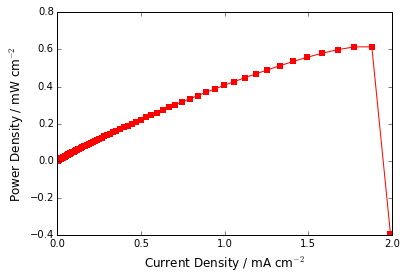

In [66]:
plot(icell*1000, V_cell*icell*1000,'s-')
xlabel('Current Density / mA cm$^{-2}$')
ylabel('Power Density / mW cm$^{-2}$')s
show()